# Fine-tuning for Natural Language Inference

This notebook demonstrates how to fine-tune a transformer-based model (e.g., RoBERTa) on the MNLI subset of the GLUE benchmark using 🤗 Hugging Face Transformers and Datasets libraries.

The MNLI task involves classifying the relationship between a pair of sentences (premise and hypothesis) into one of three categories:

- Entailment: The hypothesis logically follows from the premise.
- Neutral: The hypothesis cannot be determined as true or false based on the premise.
- Contradiction: The hypothesis contradicts the premise.

The description of the dataset is available on: https://huggingface.co/datasets/nyu-mll/glue

## 📦 Imports and Setup

In [ ]:
# Import necessary libraries
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)
from time import time
from datasets import *
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer
from sklearn.metrics import *
import matplotlib.pyplot as plt
import torch
print("Is CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs available:", torch.cuda.device_count())

Is CUDA available: True
CUDA version: 11.8
Number of GPUs available: 1


## 📊 Data Loading

The MNLI dataset is loaded from the GLUE benchmark and it is filtered to only include examples where the premise is shorter than 20 characters. This helps reduce training time.

In [ ]:
# Load the MNLI dataset
dataset = load_dataset("glue", "mnli")
dataset

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

For the sole purpose of not delaying training times, the dataset will be filtered and only the records that have a _premise_ field length of less than 20 will be kept.

In [ ]:
# Filter the dataset to keep only records with a premise length of less than 20
def filter_rows(x):
    return len(x['premise'])<20

ds_tarea = dataset.filter(filter_rows)
ds_tarea

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 13635
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 413
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 296
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 382
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 288
    })
})

## 🧪 Tokenization and Model Setup

A preprocessing function is defined to tokenize the premise and hypothesis pairs using a pretrained tokenizer. On the other hand, the pretrained RoBERTa model for sequence classification was loaded.

In [ ]:
# Model configuration
model_checkpoint = "roberta-base"

# Tokenizer definition
tokenizer = AutoTokenizer.from_pretrained(
    model_checkpoint,
    device=0 # Move model to GPU
)

# Model definition
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, 
    num_labels=3, # MNLI has three labels: entailment, neutral, contradiction
)
model = model.to("cuda") # Move model to GPU

In [ ]:
# Pre-processing function definition
def preprocess_function(x):
    inputs = tokenizer(
        x["premise"],
        x["hypothesis"],
        truncation=True,
        padding=True,
        max_length=256, 
        return_tensors="pt" 
    )

    if "label" in x and not isinstance(x.get("premise"), str):
        inputs["labels"] = x["label"]

    return inputs

# Data pre-processing
tokenized_ds = ds_tarea.map(
    preprocess_function,
    batched=True,
    remove_columns=["premise", "hypothesis", "idx"]
)

# Data collator definition
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer
    )

## 🏋️ Training the Model

The training arguments are configured and the Hugging Facee Trainer API is used to fine-tune the model.


In [ ]:
seed = 99 # Set random seed for reproducibility

# Training arguments
training_args = TrainingArguments(
    output_dir = './results',
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2, 
    
    # Anti-overfitting
    learning_rate=2e-5,
    weight_decay=0.01,

    do_train=True, 
    eval_strategy="steps",
    eval_steps=300, 
    save_strategy="steps",
    save_steps=300,
    logging_dir="./logs",
    logging_steps=100,

    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    save_total_limit=2,

    seed=seed
)

# Trainer definition
trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=tokenized_ds['train'],
    eval_dataset=tokenized_ds['validation_matched'],
    tokenizer=tokenizer,
    data_collator=data_collator
)


In [ ]:
# Training the model
start = time()

trainer.train()

end = time()
print(f">>>>>>>>>>>>> elapsed time: {(end-start)/60:.0f}m")

## 📈 Evaluation and Predictions

The model is evaluated on the validation sets and predictions are generated.


In [ ]:
# Evaluation
sample = ds_tarea['validation_matched'][0]
inputs = preprocess_function(sample)
for key, value in inputs.items():
    if isinstance(value, torch.Tensor):
        print(f"{key} es una instancia de torch.Tensor") # Check if the value is a tensor
    else:
        print(f"{key} no es una instancia de torch.Tensor") # Check if the value is not a tensor

In [ ]:
# Evaluation on validation sets
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Function to evaluate the model on validation sets
def predict(x):
    inputs = preprocess_function(x)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)
        return {'prediction': predictions.item()}

# Generate predictions for the validation sets
ds_predictions = ds_tarea.map(predict)
ds_predictions

*** train ***


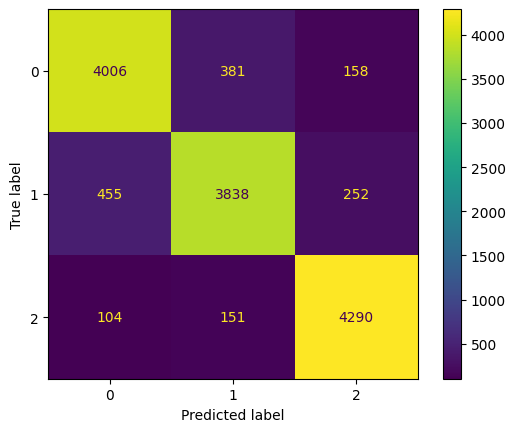

[[4006  381  158]
 [ 455 3838  252]
 [ 104  151 4290]]
*** validation_matched ***


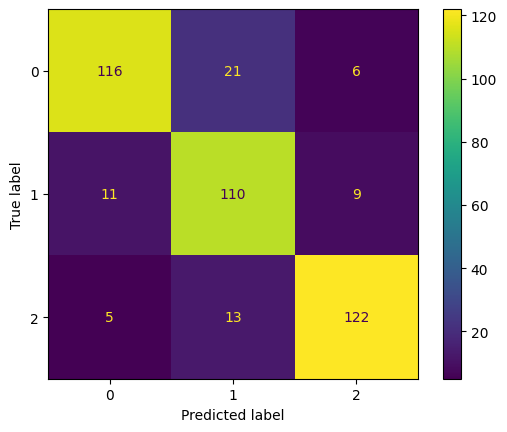

[[116  21   6]
 [ 11 110   9]
 [  5  13 122]]
*** validation_mismatched ***


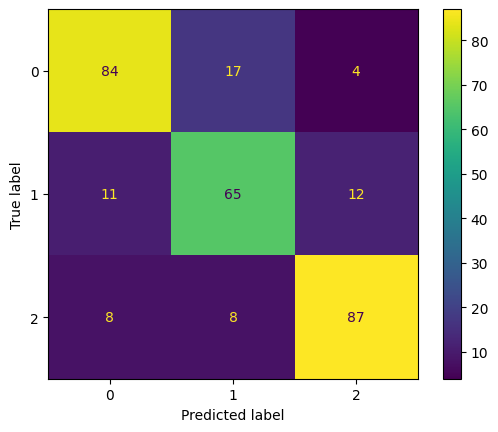

[[84 17  4]
 [11 65 12]
 [ 8  8 87]]


In [ ]:
# Confusion matrix for each subset
for subset in ['train', 'validation_matched', 'validation_mismatched']:
    y_true = ds_predictions[subset]['label']
    y_pred = ds_predictions[subset]['prediction']
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    print(f"*** {subset} ***")
    ConfusionMatrixDisplay(cm).plot()
    plt.show()
    print(cm)

Key insights:

- Training subset: the model has learned the training data well, though some overlap between Entailment (0) and Neutral (1) remains.

- Validation matched subset: the model generalizes well to in-domain validation data. Neutral (1) remains the most ambiguous class.

- Validation mismatched subset: the model is more sensitive to domain shifts, especially when distinguishing Neutral (1) from other classes. 

In [ ]:
# Calculate and print metrics for each subset
metrics = {}
for subset in ['train', 'validation_matched', 'validation_mismatched']:
    y_true = ds_predictions[subset]['label']
    y_pred = ds_predictions[subset]['prediction']
    acc = accuracy_score(y_true=y_true, y_pred=y_pred)
    pre = precision_score(y_true=y_true, y_pred=y_pred, average=None)
    rec = recall_score(y_true=y_true, y_pred=y_pred, average=None)
    metrics[subset] = [acc] + pre.tolist() + rec.tolist()
    print(f"Subset: {subset}:")
    print(f"Accuracy: {acc:.2f} | Precision0: {pre[0]:.2f} | Precision1: {pre[1]:.2f} | Precision2: {pre[2]:.2f} | Recall0: {rec[0]:.2f} | Recall1: {rec[1]:.2f} | Recall2: {rec[2]:.2f}")
    print("-----\n")

Subset: train:
Accuracy: 0.89 | Precision0: 0.88 | Precision1: 0.88 | Precision2: 0.91 | Recall0: 0.88 | Recall1: 0.84 | Recall2: 0.94
-----

Subset: validation_matched:
Accuracy: 0.84 | Precision0: 0.88 | Precision1: 0.76 | Precision2: 0.89 | Recall0: 0.81 | Recall1: 0.85 | Recall2: 0.87
-----

Subset: validation_mismatched:
Accuracy: 0.80 | Precision0: 0.82 | Precision1: 0.72 | Precision2: 0.84 | Recall0: 0.80 | Recall1: 0.74 | Recall2: 0.84
-----



Key insights: 

- Training subset: high accuracy and strong precision/recall across all classes.Particularly, the model is very good at identifying contradictions (it is the class with the highest recall).

- Validation matched subset: there is a balanced performance across all classes, indicating good generalization. Precision for Neutral drops a little bit, but recall improves, i.e, the model is able to identify Neutral cases but it can mislabel other classes as Neutral sometimes. 

- Validation mismatched subset: accuracy drops a little due to how challenging the domain shift is. However, Entailment and Contradiction remain relatively stable, showing robustness. 

## ✅ Conclusions
- The model is able to generalize reasonably well. 
- Neutral is the most challenging class (it has the lowest precision and recall). 
- Contradiction is the most robust class since it maintains high precision and recall. 
- Domain shift affects the performance, which indicates the model is quite sensitive to changes in data distribution. 